<a href="https://colab.research.google.com/github/Bonifucksy/bigdatalearning/blob/master/Big_Data_HW2_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [0]:
!wget -q https://www-us.apache.org/dist/spark/spark-2.4.3/spark-2.4.3-bin-hadoop2.7.tgz

In [0]:
!tar -xvf spark-2.4.3-bin-hadoop2.7.tgz

In [0]:
!pip install -q findspark

In [0]:
# Настройка переменных окружения
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.3-bin-hadoop2.7"

In [0]:
# Получаем экземпляр спарка
import findspark
findspark.init()
from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]").getOrCreate()

In [0]:
# Загрузим данные
df = spark.read.csv('train.csv', header=True)

In [8]:
#всё загрузилось с типом "string"
df.printSchema()

root
 |-- Id: string (nullable = true)
 |-- MSSubClass: string (nullable = true)
 |-- MSZoning: string (nullable = true)
 |-- LotFrontage: string (nullable = true)
 |-- LotArea: string (nullable = true)
 |-- Street: string (nullable = true)
 |-- Alley: string (nullable = true)
 |-- LotShape: string (nullable = true)
 |-- LandContour: string (nullable = true)
 |-- Utilities: string (nullable = true)
 |-- LotConfig: string (nullable = true)
 |-- LandSlope: string (nullable = true)
 |-- Neighborhood: string (nullable = true)
 |-- Condition1: string (nullable = true)
 |-- Condition2: string (nullable = true)
 |-- BldgType: string (nullable = true)
 |-- HouseStyle: string (nullable = true)
 |-- OverallQual: string (nullable = true)
 |-- OverallCond: string (nullable = true)
 |-- YearBuilt: string (nullable = true)
 |-- YearRemodAdd: string (nullable = true)
 |-- RoofStyle: string (nullable = true)
 |-- RoofMatl: string (nullable = true)
 |-- Exterior1st: string (nullable = true)
 |-- Exteri

In [0]:
from pyspark.ml.stat import Correlation
import pandas as pd
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml import Pipeline, PipelineModel
from pyspark.sql.types import DoubleType

In [0]:
from pyspark.mllib.stat import Statistics
from pyspark.sql.types import *
import pyspark

sc=pyspark.SparkContext.getOrCreate()
sqlCtx = pyspark.SQLContext(sc)

In [0]:
#считываем csv так, чтобы колонки имели тип данных в зависимости от их содержимого
new_df1 = sqlCtx.read.format('com.databricks.spark.csv').option('header', 'true').option('inferschema', 'true').load('train.csv')

In [97]:
new_df1.printSchema()

root
 |-- MSSubClass: integer (nullable = true)
 |-- LotArea: integer (nullable = true)
 |-- OverallQual: integer (nullable = true)
 |-- OverallCond: integer (nullable = true)
 |-- YearBuilt: integer (nullable = true)
 |-- YearRemodAdd: integer (nullable = true)
 |-- BsmtFinSF1: integer (nullable = true)
 |-- BsmtFinSF2: integer (nullable = true)
 |-- BsmtUnfSF: integer (nullable = true)
 |-- TotalBsmtSF: integer (nullable = true)
 |-- 1stFlrSF: integer (nullable = true)
 |-- 2ndFlrSF: integer (nullable = true)
 |-- LowQualFinSF: integer (nullable = true)
 |-- GrLivArea: integer (nullable = true)
 |-- BsmtFullBath: integer (nullable = true)
 |-- BsmtHalfBath: integer (nullable = true)
 |-- FullBath: integer (nullable = true)
 |-- HalfBath: integer (nullable = true)
 |-- BedroomAbvGr: integer (nullable = true)
 |-- KitchenAbvGr: integer (nullable = true)
 |-- TotRmsAbvGrd: integer (nullable = true)
 |-- Fireplaces: integer (nullable = true)
 |-- GarageCars: integer (nullable = true)
 |-

In [0]:
#мне стыдно за этот момент, но я не нашёл, как нормально отфильтровать столбцы с типом "string"
new_df1 = new_df.drop("Id","MSZoning","LotFrontage","Street","Alley","LotShape","LandContour","Utilities","LotConfig","LandSlope","Neighborhood","Condition1","Condition2","BldgType","HouseStyle","RoofStyle","RoofMatl","Exterior1st","Exterior2nd","MasVnrType","MasVnrArea","ExterQual","ExterCond","Foundation","BsmtQual","BsmtCond","BsmtExposure","BsmtFinType1","BsmtFinType2","Heating","HeatingQC","CentralAir","Electrical","KitchenQual","Functional","FireplaceQu","GarageType","GarageYrBlt","GarageFinish","GarageQual","GarageCond","PavedDrive","PoolQC","Fence","MiscFeature","SaleType","SaleCondition")

In [0]:
#дальше идут 3 куска честно "адаптированного" кода с недоконца понятным мне принципом работы
columns = new_df1.columns
col_names = new_df1.columns
features = new_df1.rdd.map(lambda row: row[0:])

In [0]:
vector = VectorAssembler(inputCols=col_names, outputCol="features")
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")

stages = [vector, scaler]

pipe = Pipeline(stages=stages)

data_for_correlation = pipe.fit(new_df1).transform(new_df1).select("scaled_features")

In [60]:
correlation = Correlation.corr(data_for_correlation, "scaled_features", "pearson").collect()[0][0].toArray()

 # rename _1, _2 ... columns to their original name
new_df1 = pd.DataFrame(correlation)
new_df1["features"] = pd.Series(columns)

 # let's see the results
display(spark.createDataFrame(new_df1, schema=columns))

DataFrame[MSSubClass: double, LotArea: double, OverallQual: double, OverallCond: double, YearBuilt: double, YearRemodAdd: double, BsmtFinSF1: double, BsmtFinSF2: double, BsmtUnfSF: double, TotalBsmtSF: double, 1stFlrSF: double, 2ndFlrSF: double, LowQualFinSF: double, GrLivArea: double, BsmtFullBath: double, BsmtHalfBath: double, FullBath: double, HalfBath: double, BedroomAbvGr: double, KitchenAbvGr: double, TotRmsAbvGrd: double, Fireplaces: double, GarageCars: double, GarageArea: double, WoodDeckSF: double, OpenPorchSF: double, EnclosedPorch: double, 3SsnPorch: double, ScreenPorch: double, PoolArea: double, MiscVal: double, MoSold: double, YrSold: double, SalePrice: double, _35: string]

In [66]:
#судя по табличке Sales Price сильнее всего коррелирует с OverallQual:Overall material and finish quality
new_df1.head(34)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,features
0,1.000000,-0.139781,0.032628,-0.059316,0.027850,0.040581,-0.069836,-0.065649,-0.140759,-0.238518,-0.251758,0.307886,0.046474,0.074853,0.003491,-0.002333,0.131608,0.177354,-0.023438,0.281721,0.040380,-0.045569,-0.040110,-0.098672,-0.012579,-0.006100,-0.012037,-0.043825,-0.026030,0.008283,-0.007683,-0.013585,-0.021407,-0.084284,MSSubClass
1,-0.139781,1.000000,0.105806,-0.005636,0.014228,0.013788,0.214103,0.111170,-0.002618,0.260833,0.299475,0.050986,0.004779,0.263116,0.158155,0.048046,0.126031,0.014259,0.119690,-0.017784,0.190015,0.271364,0.154871,0.180403,0.171698,0.084774,-0.018340,0.020423,0.043160,0.077672,0.038068,0.001205,-0.014261,0.263843,LotArea
2,0.032628,0.105806,1.000000,-0.091932,0.572323,0.550684,0.239666,-0.059119,0.308159,0.537808,0.476224,0.295493,-0.030429,0.593007,0.111098,-0.040150,0.550600,0.273458,0.101676,-0.183882,0.427452,0.396765,0.600671,0.562022,0.238923,0.308819,-0.113937,0.030371,0.064886,0.065166,-0.031406,0.070815,-0.027347,0.790982,OverallQual
3,-0.059316,-0.005636,-0.091932,1.000000,-0.375983,0.073741,-0.046231,0.040229,-0.136841,-0.171098,-0.144203,0.028942,0.025494,-0.079686,-0.054942,0.117821,-0.194149,-0.060769,0.012980,-0.087001,-0.057583,-0.023820,-0.185758,-0.151521,-0.003334,-0.032589,0.070356,0.025504,0.054811,-0.001985,0.068777,-0.003511,0.043950,-0.077856,OverallCond
4,0.027850,0.014228,0.572323,-0.375983,1.000000,0.592855,0.249503,-0.049107,0.149040,0.391452,0.281986,0.010308,-0.183784,0.199010,0.187599,-0.038162,0.468271,0.242656,-0.070651,-0.174800,0.095589,0.147716,0.537850,0.478954,0.224880,0.188686,-0.387268,0.031355,-0.050364,0.004950,-0.034383,0.012398,-0.013618,0.522897,YearBuilt
5,0.040581,0.013788,0.550684,0.073741,0.592855,1.000000,0.128451,-0.067759,0.181133,0.291066,0.240379,0.140024,-0.062419,0.287389,0.119470,-0.012337,0.439046,0.183331,-0.040581,-0.149598,0.191740,0.112581,0.420622,0.371600,0.205726,0.226298,-0.193919,0.045286,-0.038740,0.005829,-0.010286,0.021490,0.035743,0.507101,YearRemodAdd
6,-0.069836,0.214103,0.239666,-0.046231,0.249503,0.128451,1.000000,-0.050117,-0.495251,0.522396,0.445863,-0.137079,-0.064503,0.208171,0.649212,0.067418,0.058543,0.004262,-0.107355,-0.081007,0.044316,0.260011,0.224054,0.296970,0.204306,0.111761,-0.102303,0.026451,0.062021,0.140491,0.003571,-0.015727,0.014359,0.386420,BsmtFinSF1
7,-0.065649,0.111170,-0.059119,0.040229,-0.049107,-0.067759,-0.050117,1.000000,-0.209294,0.104810,0.097117,-0.099260,0.014807,-0.009640,0.158678,0.070948,-0.076444,-0.032148,-0.015728,-0.040751,-0.035227,0.046921,-0.038264,-0.018227,0.067898,0.003093,0.036543,-0.029993,0.088871,0.041709,0.004940,-0.015211,0.031706,-0.011378,BsmtFinSF2
8,-0.140759,-0.002618,0.308159,-0.136841,0.149040,0.181133,-0.495251,-0.209294,1.000000,0.415360,0.317987,0.004469,0.028167,0.240257,-0.422900,-0.095804,0.288886,-0.041118,0.166643,0.030086,0.250647,0.051575,0.214175,0.183303,-0.005316,0.129005,-0.002538,0.020764,-0.012579,-0.035092,-0.023837,0.034888,-0.041258,0.214479,BsmtUnfSF
9,-0.238518,0.260833,0.537808,-0.171098,0.391452,0.291066,0.522396,0.104810,0.415360,1.000000,0.819530,-0.174512,-0.033245,0.454868,0.307351,-0.000315,0.323722,-0.048804,0.050450,-0.068901,0.285573,0.339519,0.434585,0.486665,0.232019,0.247264,-0.095478,0.037384,0.084489,0.126053,-0.018479,0.013196,-0.014969,0.613581,TotalBsmtSF


In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

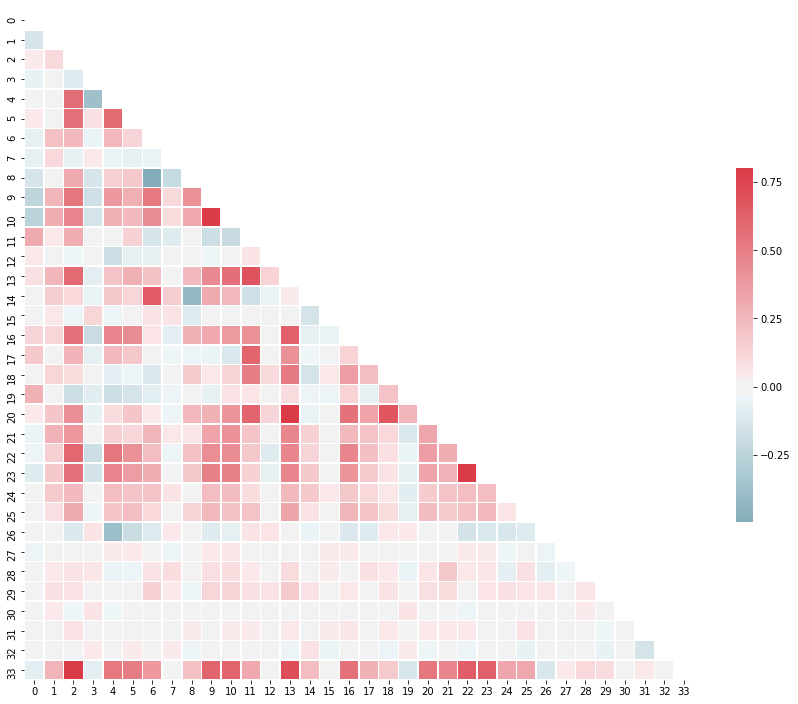

In [79]:
#Ещё один "адаптированный" кусок кода, который отрисовывает коррелляцию на графике
# Generate a mask for the upper triangle
mask = np.zeros_like(correlation, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 13))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation, mask=mask, cmap=cmap, vmax=0.8, center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.5})

In [84]:
house_df = sqlCtx.read.format('com.databricks.spark.csv').options(header='true', inferschema='true').load('train.csv')
house_df.take(1)

[Row(Id=1, MSSubClass=60, MSZoning='RL', LotFrontage='65', LotArea=8450, Street='Pave', Alley='NA', LotShape='Reg', LandContour='Lvl', Utilities='AllPub', LotConfig='Inside', LandSlope='Gtl', Neighborhood='CollgCr', Condition1='Norm', Condition2='Norm', BldgType='1Fam', HouseStyle='2Story', OverallQual=7, OverallCond=5, YearBuilt=2003, YearRemodAdd=2003, RoofStyle='Gable', RoofMatl='CompShg', Exterior1st='VinylSd', Exterior2nd='VinylSd', MasVnrType='BrkFace', MasVnrArea='196', ExterQual='Gd', ExterCond='TA', Foundation='PConc', BsmtQual='Gd', BsmtCond='TA', BsmtExposure='No', BsmtFinType1='GLQ', BsmtFinSF1=706, BsmtFinType2='Unf', BsmtFinSF2=0, BsmtUnfSF=150, TotalBsmtSF=856, Heating='GasA', HeatingQC='Ex', CentralAir='Y', Electrical='SBrkr', 1stFlrSF=856, 2ndFlrSF=854, LowQualFinSF=0, GrLivArea=1710, BsmtFullBath=1, BsmtHalfBath=0, FullBath=2, HalfBath=1, BedroomAbvGr=3, KitchenAbvGr=1, KitchenQual='Gd', TotRmsAbvGrd=8, Functional='Typ', Fireplaces=0, FireplaceQu='NA', GarageType='Att

In [85]:
house_df.cache()

DataFrame[Id: int, MSSubClass: int, MSZoning: string, LotFrontage: string, LotArea: int, Street: string, Alley: string, LotShape: string, LandContour: string, Utilities: string, LotConfig: string, LandSlope: string, Neighborhood: string, Condition1: string, Condition2: string, BldgType: string, HouseStyle: string, OverallQual: int, OverallCond: int, YearBuilt: int, YearRemodAdd: int, RoofStyle: string, RoofMatl: string, Exterior1st: string, Exterior2nd: string, MasVnrType: string, MasVnrArea: string, ExterQual: string, ExterCond: string, Foundation: string, BsmtQual: string, BsmtCond: string, BsmtExposure: string, BsmtFinType1: string, BsmtFinSF1: int, BsmtFinType2: string, BsmtFinSF2: int, BsmtUnfSF: int, TotalBsmtSF: int, Heating: string, HeatingQC: string, CentralAir: string, Electrical: string, 1stFlrSF: int, 2ndFlrSF: int, LowQualFinSF: int, GrLivArea: int, BsmtFullBath: int, BsmtHalfBath: int, FullBath: int, HalfBath: int, BedroomAbvGr: int, KitchenAbvGr: int, KitchenQual: string

In [98]:
house_df.printSchema()

root
 |-- Id: integer (nullable = true)
 |-- MSSubClass: integer (nullable = true)
 |-- MSZoning: string (nullable = true)
 |-- LotFrontage: string (nullable = true)
 |-- LotArea: integer (nullable = true)
 |-- Street: string (nullable = true)
 |-- Alley: string (nullable = true)
 |-- LotShape: string (nullable = true)
 |-- LandContour: string (nullable = true)
 |-- Utilities: string (nullable = true)
 |-- LotConfig: string (nullable = true)
 |-- LandSlope: string (nullable = true)
 |-- Neighborhood: string (nullable = true)
 |-- Condition1: string (nullable = true)
 |-- Condition2: string (nullable = true)
 |-- BldgType: string (nullable = true)
 |-- HouseStyle: string (nullable = true)
 |-- OverallQual: integer (nullable = true)
 |-- OverallCond: integer (nullable = true)
 |-- YearBuilt: integer (nullable = true)
 |-- YearRemodAdd: integer (nullable = true)
 |-- RoofStyle: string (nullable = true)
 |-- RoofMatl: string (nullable = true)
 |-- Exterior1st: string (nullable = true)
 |--

In [87]:
house_df.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
Id,1460,730.5,421.6100093688479,1,1460
MSSubClass,1460,56.897260273972606,42.30057099381045,20,190
MSZoning,1460,None,None,C (all),RM
LotFrontage,1460,70.04995836802665,24.28475177448321,100,NA
LotArea,1460,10516.828082191782,9981.26493237915,1300,215245
Street,1460,None,None,Grvl,Pave
Alley,1460,None,None,Grvl,Pave
LotShape,1460,None,None,IR1,Reg
LandContour,1460,None,None,Bnk,Lvl


In [92]:
#оказывается корреляцию можно было посчитать много проще
import six
for i in house_df.columns:
    if not( isinstance(house_df.select(i).take(1)[0][0], six.string_types)):
        print( "Correlation to SalePrice for ", i, house_df.stat.corr('SalePrice',i))

Correlation to SalePrice for  Id -0.021916719443430967
Correlation to SalePrice for  MSSubClass -0.08428413512659509
Correlation to SalePrice for  LotArea 0.2638433538714051
Correlation to SalePrice for  OverallQual 0.7909816005838053
Correlation to SalePrice for  OverallCond -0.07785589404867796
Correlation to SalePrice for  YearBuilt 0.522897332879497
Correlation to SalePrice for  YearRemodAdd 0.5071009671113869
Correlation to SalePrice for  BsmtFinSF1 0.38641980624215344
Correlation to SalePrice for  BsmtFinSF2 -0.011378121450215155
Correlation to SalePrice for  BsmtUnfSF 0.21447910554696925
Correlation to SalePrice for  TotalBsmtSF 0.6135805515591942
Correlation to SalePrice for  1stFlrSF 0.6058521846919153
Correlation to SalePrice for  2ndFlrSF 0.3193338028320674
Correlation to SalePrice for  LowQualFinSF -0.02560613000067957
Correlation to SalePrice for  GrLivArea 0.7086244776126517
Correlation to SalePrice for  BsmtFullBath 0.22712223313149418
Correlation to SalePrice for  BsmtH

In [100]:
from pyspark.ml.feature import VectorAssembler
vectorAssembler = VectorAssembler(inputCols = ['MSSubClass','LotArea','OverallQual','OverallCond','YearBuilt','YearRemodAdd','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr','TotRmsAbvGrd','Fireplaces','GarageCars','GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal','MoSold','YrSold','SalePrice'], outputCol = 'features')
vhouse_df = vectorAssembler.transform(house_df)
vhouse_df = vhouse_df.select(['features', 'SalePrice'])
vhouse_df.show(33)

+--------------------+---------+
|            features|SalePrice|
+--------------------+---------+
|[60.0,8450.0,7.0,...|   208500|
|[20.0,9600.0,6.0,...|   181500|
|[60.0,11250.0,7.0...|   223500|
|[70.0,9550.0,7.0,...|   140000|
|[60.0,14260.0,8.0...|   250000|
|[50.0,14115.0,5.0...|   143000|
|[20.0,10084.0,8.0...|   307000|
|[60.0,10382.0,7.0...|   200000|
|[50.0,6120.0,7.0,...|   129900|
|[190.0,7420.0,5.0...|   118000|
|(34,[0,1,2,3,4,5,...|   129500|
|[60.0,11924.0,9.0...|   345000|
|[20.0,12968.0,5.0...|   144000|
|[20.0,10652.0,7.0...|   279500|
|[20.0,10920.0,6.0...|   157000|
|(34,[0,1,2,3,4,5,...|   132000|
|[20.0,11241.0,6.0...|   149000|
|(34,[0,1,2,3,4,5,...|    90000|
|[20.0,13695.0,5.0...|   159000|
|(34,[0,1,2,3,4,5,...|   139000|
|[60.0,14215.0,8.0...|   325300|
|(34,[0,1,2,3,4,5,...|   139400|
|[20.0,9742.0,8.0,...|   230000|
|[120.0,4224.0,5.0...|   129900|
|[20.0,8246.0,5.0,...|   154000|
|(34,[0,1,2,3,4,5,...|   256300|
|[20.0,7200.0,5.0,...|   134800|
|[20.0,114

In [0]:
splits = vhouse_df.randomSplit([0.7, 0.3])
train_df = splits[0]
test_df = splits[1]

In [102]:
#регрессию считают тут, но мне не очень понятно, что это значит в данном случае
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol = 'features', labelCol='SalePrice', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(train_df)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [-54.35231325623433,0.12443008940513609,4170.60477780118,1153.866387677939,54.26366367923392,0.0,3.8303820643509483,-1.0124996080138153,-0.20120693266750325,0.0,6.388065580262538,4.7712305441047835,3.55363474728611,11.613267621253351,1490.2995992225838,1199.1214253827798,1197.3163688828106,545.5638465868333,-6058.72649918499,-3177.2313508054935,404.5759039327082,0.0,2520.1103140516716,-7.901160634137135,3.3165571600784154,-19.662268675573138,2.4103102636092077,-12.311842049821847,13.548914743236605,-38.6833519193348,-0.009782281492411862,49.01108864459922,-602.9049165680946,0.894102135388886]
Intercept: 1079078.700036816


In [103]:
#что происходит дальше - для меня загадка
trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 8591.729085
r2: 0.988260


In [104]:
train_df.describe().show()

+-------+------------------+
|summary|         SalePrice|
+-------+------------------+
|  count|              1026|
|   mean|181772.49220272904|
| stddev| 79332.84761804985|
|    min|             34900|
|    max|            755000|
+-------+------------------+



In [107]:
lr_predictions = lr_model.transform(test_df)
lr_predictions.select("prediction","SalePrice","features").show(5)
from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="SalePrice",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

+------------------+---------+--------------------+
|        prediction|SalePrice|            features|
+------------------+---------+--------------------+
| 61946.53377376031|    75500|(34,[0,1,2,3,4,5,...|
| 148474.6313218975|   166000|(34,[0,1,2,3,4,5,...|
|122553.78882847412|   130500|(34,[0,1,2,3,4,5,...|
|139594.07365309715|   145000|(34,[0,1,2,3,4,5,...|
| 147237.3295160283|   154300|(34,[0,1,2,3,4,5,...|
+------------------+---------+--------------------+
only showing top 5 rows

R Squared (R2) on test data = 0.987988


In [108]:
test_result = lr_model.evaluate(test_df)
print("Root Mean Squared Error (RMSE) on test data = %g" % test_result.rootMeanSquaredError)

Root Mean Squared Error (RMSE) on test data = 8731.08


In [109]:
print("numIterations: %d" % trainingSummary.totalIterations)
print("objectiveHistory: %s" % str(trainingSummary.objectiveHistory))
trainingSummary.residuals.show()

numIterations: 11
objectiveHistory: [0.49999999999999956, 0.3878646433988482, 0.15858559867204622, 0.09554042431371076, 0.07521809419668904, 0.06061686534262281, 0.052522996980512986, 0.026788590828867444, 0.011616835969643285, 0.008530733265303014, 0.005874787129894322]
+-------------------+
|          residuals|
+-------------------+
|  8752.267447202117|
| 13154.840624667704|
|  9047.141228376888|
| 12346.420366025064|
|  3733.112418479868|
| 14853.338941846974|
| 29192.300979450112|
|-2721.3737803765107|
|   761.670474577113|
|  4878.805110715795|
|  4859.232060866663|
|  6363.323233647738|
| 3250.9623316496145|
|  4830.485101875267|
|  5555.596505050082|
| 1396.2728105761344|
| 253.57365933142137|
|  10369.32426730753|
|  5696.163858100539|
|-391.16192705370486|
+-------------------+
only showing top 20 rows



In [110]:
predictions = lr_model.transform(test_df)
predictions.select("prediction","SalePrice","features").show()

+------------------+---------+--------------------+
|        prediction|SalePrice|            features|
+------------------+---------+--------------------+
| 61946.53377376031|    75500|(34,[0,1,2,3,4,5,...|
| 148474.6313218975|   166000|(34,[0,1,2,3,4,5,...|
|122553.78882847412|   130500|(34,[0,1,2,3,4,5,...|
|139594.07365309715|   145000|(34,[0,1,2,3,4,5,...|
| 147237.3295160283|   154300|(34,[0,1,2,3,4,5,...|
|129042.88433395617|   136500|(34,[0,1,2,3,4,5,...|
|127940.50022401102|   129900|(34,[0,1,2,3,4,5,...|
|135441.01721543702|   139000|(34,[0,1,2,3,4,5,...|
|147671.30218558456|   150750|(34,[0,1,2,3,4,5,...|
|135964.79387268517|   139950|(34,[0,1,2,3,4,5,...|
|133731.45887118764|   139000|(34,[0,1,2,3,4,5,...|
|145477.84027709404|   145000|(34,[0,1,2,3,4,5,...|
|108411.48838785302|   109900|(34,[0,1,2,3,4,5,...|
|113746.45963486843|   125000|(34,[0,1,2,3,4,5,...|
|184069.58134463115|   188000|(34,[0,1,2,3,4,5,...|
|143991.47724575992|   141000|(34,[0,1,2,3,4,5,...|
|  86646.697

In [111]:
from pyspark.ml.regression import DecisionTreeRegressor
dt = DecisionTreeRegressor(featuresCol ='features', labelCol = 'SalePrice')
dt_model = dt.fit(train_df)
dt_predictions = dt_model.transform(test_df)
dt_evaluator = RegressionEvaluator(
    labelCol="SalePrice", predictionCol="prediction", metricName="rmse")
rmse = dt_evaluator.evaluate(dt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 20035.2


In [112]:
dt_model.featureImportances

SparseVector(34, {0: 0.0005, 1: 0.0018, 9: 0.0158, 10: 0.0006, 13: 0.0001, 16: 0.0201, 21: 0.004, 25: 0.0006, 28: 0.0037, 33: 0.9528})

In [113]:
house_df.take(1)

[Row(Id=1, MSSubClass=60, MSZoning='RL', LotFrontage='65', LotArea=8450, Street='Pave', Alley='NA', LotShape='Reg', LandContour='Lvl', Utilities='AllPub', LotConfig='Inside', LandSlope='Gtl', Neighborhood='CollgCr', Condition1='Norm', Condition2='Norm', BldgType='1Fam', HouseStyle='2Story', OverallQual=7, OverallCond=5, YearBuilt=2003, YearRemodAdd=2003, RoofStyle='Gable', RoofMatl='CompShg', Exterior1st='VinylSd', Exterior2nd='VinylSd', MasVnrType='BrkFace', MasVnrArea='196', ExterQual='Gd', ExterCond='TA', Foundation='PConc', BsmtQual='Gd', BsmtCond='TA', BsmtExposure='No', BsmtFinType1='GLQ', BsmtFinSF1=706, BsmtFinType2='Unf', BsmtFinSF2=0, BsmtUnfSF=150, TotalBsmtSF=856, Heating='GasA', HeatingQC='Ex', CentralAir='Y', Electrical='SBrkr', 1stFlrSF=856, 2ndFlrSF=854, LowQualFinSF=0, GrLivArea=1710, BsmtFullBath=1, BsmtHalfBath=0, FullBath=2, HalfBath=1, BedroomAbvGr=3, KitchenAbvGr=1, KitchenQual='Gd', TotRmsAbvGrd=8, Functional='Typ', Fireplaces=0, FireplaceQu='NA', GarageType='Att

In [114]:
from pyspark.ml.regression import GBTRegressor
gbt = GBTRegressor(featuresCol = 'features', labelCol = 'SalePrice', maxIter=10)
gbt_model = gbt.fit(train_df)
gbt_predictions = gbt_model.transform(test_df)
gbt_predictions.select('prediction', 'SalePrice', 'features').show(5)

+------------------+---------+--------------------+
|        prediction|SalePrice|            features|
+------------------+---------+--------------------+
| 72511.39324861814|    75500|(34,[0,1,2,3,4,5,...|
|168736.19334573232|   166000|(34,[0,1,2,3,4,5,...|
|136095.84836092987|   130500|(34,[0,1,2,3,4,5,...|
| 145983.5668982565|   145000|(34,[0,1,2,3,4,5,...|
|154117.00000358315|   154300|(34,[0,1,2,3,4,5,...|
+------------------+---------+--------------------+
only showing top 5 rows



In [115]:
gbt_evaluator = RegressionEvaluator(
    labelCol="SalePrice", predictionCol="prediction", metricName="rmse")
rmse = gbt_evaluator.evaluate(gbt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 19645.4
